In [1]:
#allow cool inline matploblib graphs in jupyter
%matplotlib notebook  

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from   scipy.spatial import distance
import time
import copy
import os
from   itertools import combinations
import sys
import roboticstoolbox as rtb

from autonomous_task_base import atb  #collection of functions

# Task & Product
A task is defined as the collection of points on the product
that the end-effector of the robot needs to reach. Tasks can be categorized in terms of their distribution around
the product. Applications where the end-effector of the robot needs to cover an entire surface such as painting
or grit blasting are categorized as continuous tasks. Whereas, applications where the end-effector needs to visit
individual points or small clusters of points around the product are categorized as discrete tasks. A product
is defined as the object on which the industrial application is to be performed.

Both are .csv files with coordinates. To distinguish between *discrete* and *continuous* tasks an additional flag is added to the .csv file. *d* for discrete, *c* for contiuous.  

In [7]:
product1 = "tasks/i_beam/perpendicular/i_perpendicular_product1.csv"
product2 = "tasks/i_beam/perpendicular/i_perpendicular_product2.csv"
task     = "tasks/i_beam/perpendicular/i_perpendicular_task_2.csv"

This example uses the [UR10](https://www.universal-robots.com/products/ur10-robot/) as the industrial robot placed on a [Summit XL Steel](https://robotnik.eu/products/mobile-robots/summit-xl-steel-en/)

We can now intialize everything before we start the calculations.  

In [26]:
robot_coverage = rtb.models.DH.UR10()  #different robots can be used for different applications, 
robot_discrete = rtb.models.DH.UR10()  #in this case both robots are the same
agv = 510                              #height of the AGV

buffer_in  = 300                       #buffers are used to create the search space around the i-beams
buffer_out = 1250

robot_max_reach_coverage = 1.3         #maximum reach of the robots
robot_max_reach_discrete = 1.3

resolution = 25                        #resolution of the discretization of the search space 

x_product_1 = pd.read_csv(product1, usecols =[0], header=None)
y_product_1 = pd.read_csv(product1, usecols =[2], header=None)
z_product_1 = pd.read_csv(product1, usecols =[1], header=None)

df_product1      = pd.read_csv(product1, header=None)
dropped_product1 = df_product1[[0,2,1]]
point_data_product1 = dropped_product1.values.tolist() 

x_product_2 = pd.read_csv(product2, usecols =[0], header=None)
y_product_2 = pd.read_csv(product2, usecols =[2], header=None)
z_product_2 = pd.read_csv(product2, usecols =[1], header=None)

df_product2         = pd.read_csv(product2, header=None)
dropped_product2    = df_product2[[0,2,1]]
point_data_product2 = dropped_product2.values.tolist() 

df_task = pd.read_csv(task, header=None)
flags   = df_task[3].values.tolist()

point_data_task    = df_task[[0,2,1]].values.tolist()
point_data_task_2d = df_task[[0,2]].values.tolist()

point_data_discrete    = []
point_data_discrete_2d = []
point_data_coverage    = []

#separate the task into discrete and continuous parts
for i in range(len(flags)):
    if flags[i] == "c":
        point_data_coverage.append(point_data_task[i])
    elif flags[i] == "d":
        point_data_discrete.append(point_data_task[i])

#% Create the I-beams
Z1 = np.array(point_data_product1)
Z2 = np.array(point_data_product2)
verts1 = [[Z1[0],  Z1[1], Z1[2], Z1[3]],
          [Z1[4],  Z1[5], Z1[6], Z1[7]],
          [Z1[8],  Z1[9], Z1[10],Z1[11]],
          [Z1[12], Z1[13],Z1[14],Z1[15]],
          
          [Z1[16], Z1[17],Z1[18],Z1[19]],
          [Z1[20], Z1[21],Z1[22],Z1[23]],
          [Z1[20], Z1[21],Z1[10],Z1[11]],
          [Z1[8],  Z1[9], Z1[22],Z1[23]],
          
          [Z1[12], Z1[15],Z1[2], Z1[1]],
          [Z1[13], Z1[14],Z1[3], Z1[0]],
          [Z1[21], Z1[22],Z1[9], Z1[10]],
          [Z1[20], Z1[23],Z1[8], Z1[11]],
          [Z1[0],  Z1[1],Z1[12],Z1[13]],
          [Z1[2],  Z1[3],Z1[14],Z1[15]],
          [Z1[4],  Z1[17],Z1[18],Z1[7]],
          [Z1[5],  Z1[6], Z1[19],Z1[16]],
]

verts2 = [[Z2[0], Z2[1], Z2[2], Z2[3]],
          [Z2[4], Z2[5], Z2[6], Z2[7]],
          [Z2[8], Z2[9], Z2[10],Z2[11]],
          [Z2[12],Z2[13],Z2[14],Z2[15]],
          
          [Z2[16],Z2[17],Z2[18],Z2[19]],
          [Z2[20],Z2[21],Z2[22],Z2[23]],
          [Z2[4], Z2[7], Z2[18],Z2[17]],
          [Z2[16],Z2[19],Z2[6], Z2[5]],
          [Z2[0], Z2[1], Z2[12],Z2[13]],
          [Z2[0], Z2[3], Z2[14],Z2[13]],
          [Z2[12],Z2[15],Z2[2], Z2[1]],
          [Z2[9], Z2[10],Z2[21],Z2[22]],
          [Z2[8], Z2[11],Z2[20],Z2[23]],
          [Z2[8], Z2[9], Z2[22],Z2[23]],
          [Z2[10],Z2[11],Z2[20],Z2[21]],
]
#create the bounding boxes around the I-beams
bounding_box1 = []
line1 = np.linspace(Z1[9], Z1[10],10)
line2 = np.linspace(Z1[10],Z1[21],30)
line3 = np.linspace(Z1[21],Z1[22],10)
line4 = np.linspace(Z1[22],Z1[9], 30)

bounding_box1.append(line1)
bounding_box1.append(line2)
bounding_box1.append(line3)
bounding_box1.append(line4)

bounding_box2 = []
line5 = np.linspace(Z2[9], Z2[10],10)
line6 = np.linspace(Z2[10],Z2[21],30)
line7 = np.linspace(Z2[21],Z2[22],10)
line8 = np.linspace(Z2[22],Z2[9], 30)

bounding_box2.append(line5)
bounding_box2.append(line6)
bounding_box2.append(line7)
bounding_box2.append(line8)


#list of inputs saved for later       
inputs = []
inputs.append(resolution)            #0
inputs.append(buffer_in)             #1
inputs.append(buffer_out)            #2
inputs.append(point_data_discrete)   #3
inputs.append(point_data_coverage)   #4
inputs.append(agv)                   #5
inputs.append(bounding_box1)         #6
inputs.append(bounding_box2)         #7

colors = ["red","blue","orange","green","brown","magenta","gray","yellow","cyan", "purple"]
colors_discrete = ["black","fuchsia","hotpink","peru","darkslategray","gold","lime"]

Plot of the task and the products

<IPython.core.display.Javascript object>


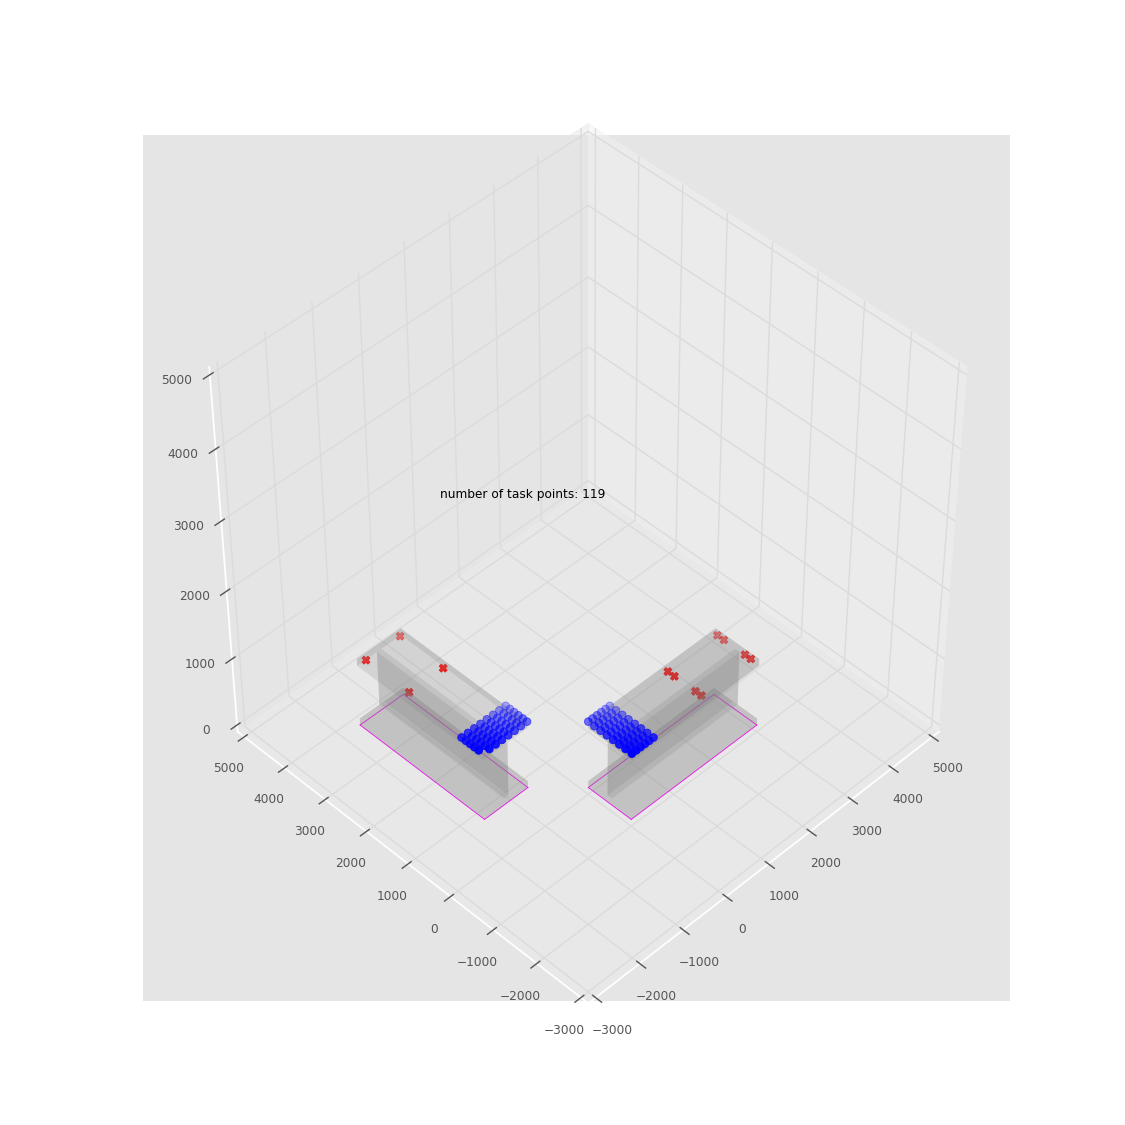

In [25]:
fig = plt.figure(plt.figure(figsize=(9,9)))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((1,1,1)) #change box aspect
ax.add_collection3d(Poly3DCollection(verts1, facecolors='gray', edgecolors = "gray",linewidths=0, alpha=.2))
ax.add_collection3d(Poly3DCollection(verts2, facecolors='gray', edgecolors = "gray",linewidths=0, alpha=.2))

ax.scatter(np.array(point_data_coverage)[:,0],
           np.array(point_data_coverage)[:,1],
           np.array(point_data_coverage)[:,2],
           marker = "o",
           c = "blue"  )
ax.scatter(np.array(point_data_discrete)[:,0],
           np.array(point_data_discrete)[:,1],
           np.array(point_data_discrete)[:,2],
           marker = "X",
           c = "red")
for i in range(len(bounding_box1)):
   ax.plot(np.array(bounding_box1[i])[:,0],
              np.array(bounding_box1[i])[:,1],
              np.array(bounding_box1[i])[:,2],
              color = "magenta")
for i in range(len(bounding_box2)):
   
   ax.plot(np.array(bounding_box2[i])[:,0],
          np.array(bounding_box2[i])[:,1],
          np.array(bounding_box2[i])[:,2],
          color = "magenta")
ax.text(3000,6700,0,"number of task points: "+str (len(point_data_coverage) + len(point_data_discrete)))
ax.set_xlim(-3000,5000)
ax.set_ylim(-3000,5000)
ax.set_zlim(0,5000)
ax.view_init(elev = 45, azim = -135)
plt.show()   

# Solution Method

* The task points in the csv files are grouped into clusters using the OPTICS or the K-Means Clustering algorithm depending on the application. 
* Afterwards a search space is created around the product based on the maximum reach of the robot and the minimum distance the robot can approach the product without collisions. Similarly, cluster search spaces are created around the centroids of the clusters resulting from the clustering algorithms.
* On the overlapping sections of the search space around the product and the search spaces of clusters, a lattice of linearly or radially(depending on the shape of the product) distributed points are placed. These points are defined as Possible Base Positions.
* Afterwards, Reachability Vectors are created at each possible base placement. These vectors are arrays of ones and zeros representing whether a certain point of the task can be reached from that base placement. This is done be calculating the inverse kinematics between the possible base placement and every point in the task.

* To determine which combinations of possible base placements can fulfill the entire task, all combinations(up to a user defined maximum number) of Reachability Vectors are added together. The combinations that ensure full coverage are designated as Valid Combinations. 

* Lastly, each Valid Combination is scored according to the number of bases, distance between these bases, maximum torque on robot joints. 
* Finally, the combination with the highest score is selected as the Final Combination, i.e. the solution of the problem

Here is the flowchart:

<div>
<img src="images/flowchart.jpeg" width="500"/>
</div>

`Shapely` library is used to create the discretized search space around the I-beams  

In [10]:
#%CREATE SEARCH SPACE
ss_results = atb.search_space(inputs)

ss                 = ss_results[0]
inner_bound1       = ss_results[1]
inner_bound2       = ss_results[2]
common_ss_exterior = ss_results[3]
points             = ss_results[4]
z_in1 = []
for i in range(len(inner_bound1)):
    z_in1.append(0)
    
z_in2 = []
for i in range(len(inner_bound2)):
    z_in2.append(0)


This is what the discretized search space looks like.  
The points that also fall into the search spaces around the clusters will be *Possible Base Placements* or *PBPs*

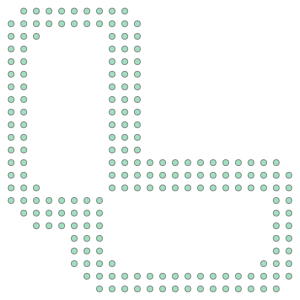

In [11]:
ss

In [13]:
#%COVERAGE TASK
coverage_task_results = atb.coverage_task(inputs, 2, ss)
pbp_coverage_coords   = coverage_task_results[0]
centroids_coverage    = coverage_task_results[1]
clusters_coverage     = coverage_task_results[2]
centroids_ss_kmeans   = coverage_task_results[3]
#%
# pbp_kmeans = []
# final_ss_kmeans = {}
# for i in range(len(centroids_ss_kmeans)):
#     final_ss_kmeans[i] = centroids_ss_kmeans[i].intersection(ss)
# for i in range(len(final_ss_kmeans)-1):
#     pbp_kmeans = final_ss_kmeans[i].union(final_ss_kmeans[i+1])
 #%

##%DISCRETE TASK
discrete_task_results = atb.discrete_task(inputs, 3, ss)
pbp_discrete_coords   = discrete_task_results[0]
centroids_discrete    = discrete_task_results[1]
clusters_discrete     = discrete_task_results[2]

C:\Users\ege_b\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass min_samples=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


<IPython.core.display.Javascript object>


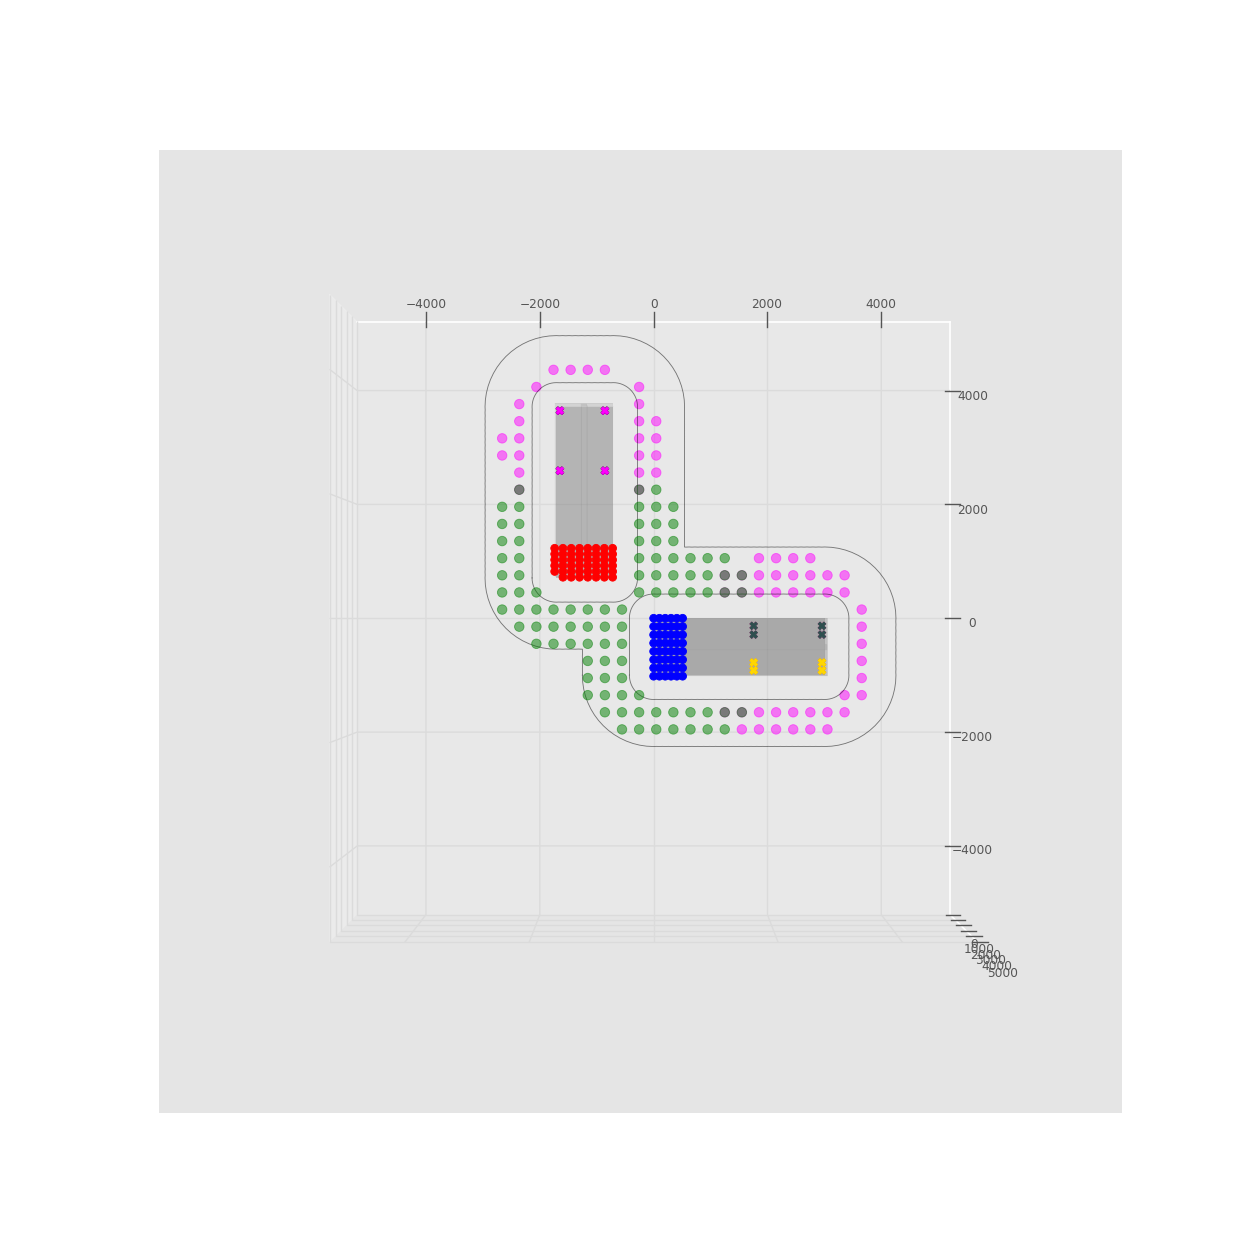

In [14]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(np.array(pbp_discrete_coords)[:,0],
                np.array(pbp_discrete_coords)[:,1],
                0,
                s = 30 , alpha = 0.5, c = "magenta")
ax.scatter(np.array(pbp_coverage_coords)[:,0],
                np.array(pbp_coverage_coords)[:,1],
                0,
                s = 30 , alpha = 0.5, c = "green")
 
ax.add_collection3d(Poly3DCollection(verts1, facecolors='gray', edgecolors = "gray",linewidths=0, alpha=.2))
ax.add_collection3d(Poly3DCollection(verts2, facecolors='gray', edgecolors = "gray",linewidths=0, alpha=.2))


for i in range(len(clusters_discrete)):
    ax.scatter(np.array(clusters_discrete[i])[:,0],
                    np.array(clusters_discrete[i])[:,1],
                    np.array(clusters_discrete[i])[:,2],
                    c= colors_discrete[i],
                    marker = "X")
    
for i in range(len(clusters_coverage)):
    ax.scatter(np.array(clusters_coverage[i])[:,0],
                    np.array(clusters_coverage[i])[:,1],
                    np.array(clusters_coverage[i])[:,2],
                    c= colors[i],
                    marker = "o")    
ax.plot3D(np.array(inner_bound1)[:,0],
               np.array(inner_bound1)[:,1],
               np.array(z_in1),
               c = "black",  alpha = 0.5 )
ax.plot3D(np.array(inner_bound2)[:,0],
               np.array(inner_bound2)[:,1],
               np.array(z_in2),
               c = "black",  alpha = 0.5 )
ax.plot3D(np.array(common_ss_exterior)[:,0],
            np.array(common_ss_exterior)[:,1],
            np.array(common_ss_exterior)[:,2],
            c = "black", alpha = 0.5)

    
ax.set_xlim(-5000,5000)
ax.set_ylim(-5000,5000)
ax.set_zlim(0,5000)
ax.view_init(elev = 90, azim = -90)
plt.show()   

After the *PBPs* have been determined *Reachability Vectors* need to be filled in. 

*Reachability Vectors* are 1-dimensional arrays consisting of ones and zeros, designating
whether a task point can be reached from that *Possible Base Position*.
At each *Possible Base Position*, inverse kinematics is applied to the entire task to determine which of the points
are reachable from that position. To reduce computational burden the task points beyond the maximum reach
of the robot from that *Possible Base Position* are not considered. If the inverse kinematics calculation returns
a result, the point is reachable from that base. If a point is reachable, the array element of the *Reachability
Vector* corresponding to that point will be 1, if not, 0. Therefore, elements of each *Reachability Vector* will
represent the reachable points from that *Possible Base Position*. Afterwards, the combinations of *Reachability
Vectors* of each *Possible Base Position* are added to one another until the sum is filled with non-zero elements.
Combinations that return a full coverage are stored as *Valid Combinations*, the rest are discarded. The number
of combinations that need to be searched is given by:

<center>$N = \sum_{i=1}^k C(k,i) = \sum_{i=1}^k \frac{k!}{i!(k-i)!} $ <center>

In [16]:
#IK FOR COVERAGE TASK
#solve IK at each pbp for all of the points, if IK returns True add 1 to reachability vector, else add 0
rel_coverage = {}
diff_coverage = []

for i in range(len(pbp_coverage_coords)):
    for j in range(len(point_data_coverage)):
        diff_coverage.append(np.subtract(point_data_coverage[j],pbp_coverage_coords[i])/1000)
        rel_coverage[i] = diff_coverage
    diff_coverage = []
    
print("\nStarting IK calculations for coverage task.")
IK_coverage                  = atb.inverse_kinematics(rel_coverage,robot_coverage,robot_max_reach_coverage,0)
reachability_vector_coverage = IK_coverage[0]
manipulability_coverage      = IK_coverage[1]

rvsums = []
for i in range(len(reachability_vector_coverage)):
    rvsums.append(sum(reachability_vector_coverage[i]))
print("Number of reachability vectors:" ,len(reachability_vector_coverage))

rv = copy.deepcopy(reachability_vector_coverage)
rvave = np.mean(rvsums)
print("Average reachability: ",rvave)

#remove the worst
print("Removing reachability vectors that can't reach that many points")
for i in range(len(reachability_vector_coverage)):
    if np.sum(reachability_vector_coverage[i]) < int(rvave/2):
        del reachability_vector_coverage[i]   
pbp_reach_coverage= {}
for i in range(len(list(reachability_vector_coverage.keys()))):
        pbp_reach_coverage[i] = reachability_vector_coverage[list(reachability_vector_coverage.keys())[i]]
print("Number of possible base positions: " ,len(pbp_reach_coverage))

pbpsums = []
for i in range(len(pbp_reach_coverage)):
    pbpsums.append(sum(pbp_reach_coverage[i]))
pbpave = np.mean(pbpsums)
print("New average reachability: " ,pbpave,"\n")



Starting IK calculations for coverage task.


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [03:32<00:00,  2.31s/it]

Number of reachability vectors: 92
Average reachability:  14.065217391304348
Removing reachability vectors that can't reach that many points
Number of possible base positions:  50
New average reachability:  24.24 



In [17]:
#% DISCRETE TASK
rel_discrete = {}
diff_discrete = []

for i in range(len(pbp_discrete_coords)):
    for j in range(len(point_data_discrete)):
        diff_discrete.append(np.subtract(point_data_discrete[j],pbp_discrete_coords[i])/1000)
        rel_discrete[i] = diff_discrete
    diff_discrete = []

print("Starting IK calculations for discrete task.")
IK_discrete                  = atb.inverse_kinematics(rel_discrete,robot_discrete,robot_max_reach_discrete,0)
reachability_vector_discrete = IK_discrete[0]
manipulability_discrete      = IK_discrete[1]

rvsums_discrete = []
for i in range(len(reachability_vector_discrete)):
    rvsums_discrete.append(sum(reachability_vector_discrete[i]))
print("Number of reachability vectors:" ,len(reachability_vector_discrete))

rv_discrete = copy.deepcopy(reachability_vector_discrete)
rvave_discrete = np.mean(rvsums_discrete)
print("Average reachability: ",rvave_discrete)

print("Removing reachability vectors that can't reach that many points")
for i in range(len(reachability_vector_discrete)):
    if np.sum(reachability_vector_discrete[i]) < 1:
        del reachability_vector_discrete[i]

pbp_reach_discrete = {}
for i in range(len(list(reachability_vector_discrete.keys()))):
        pbp_reach_discrete[i] = reachability_vector_discrete[list(reachability_vector_discrete.keys())[i]]
print("Number of possible base positions: " ,len(pbp_reach_discrete))

pbpsums_discrete = []
for i in range(len(pbp_reach_discrete)):
    pbpsums_discrete.append(sum(pbp_reach_discrete[i]))
pbpave_discrete = np.mean(pbpsums_discrete)
print("New average reachability: " ,pbpave_discrete, "\n")  
print("IK calculations are done for both tasks! Moving on with the combinations search.\n")

Starting IK calculations for discrete task.


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:20<00:00,  3.18it/s]

Number of reachability vectors: 65
Average reachability:  3.476923076923077
Removing reachability vectors that can't reach that many points
Number of possible base positions:  56
New average reachability:  4.035714285714286 

IK calculations are done for both tasks! Moving on with the combinations search.



Once the *Reachability Vectors* are filled in, combinations of them are searched through to determine which ones offer complete coverage of the task. Note that this takes a long time due to the sheer number of combinations.

In [18]:
max_combi_num = 5
combinations_results       = atb.reachability_combis(pbp_reach_coverage,max_combi_num)
valid_combos_coverage      = combinations_results[0]
incomplete_combos_coverage = combinations_results[1]
pbp_combi_coverage         = combinations_results[2]
total_checks_coverage      = combinations_results[3]


max_combi_num_discrete = 5
combinations_results         = atb.reachability_combis(pbp_reach_discrete,max_combi_num_discrete)
valid_combos_discrete        = combinations_results[0]
incomplete_combos_discrete   = combinations_results[1]
pbp_combi_discrete           = combinations_results[2]
total_checks_discrete        = combinations_results[3]

Checking combinations with 2 PBPs
There are 1225 of them


100%|████████████████████████████████████████████████████████████████████████████| 1225/1225 [00:00<00:00, 7488.86it/s]




Checking combinations with 3 PBPs
There are 20825 of them


100%|██████████████████████████████████████████████████████████████████████████| 20825/20825 [00:03<00:00, 5302.79it/s]




Checking combinations with 4 PBPs
There are 251125 of them


100%|████████████████████████████████████████████████████████████████████████| 251125/251125 [01:02<00:00, 3997.28it/s]




Checking combinations with 5 PBPs
There are 2369885 of them


100%|██████████████████████████████████████████████████████████████████████| 2369885/2369885 [12:18<00:00, 3208.51it/s]



Valid combinations are calculated!
2643060 combinations were checked
6084 valid combinations found
Checking combinations with 2 PBPs
There are 1540 of them


100%|███████████████████████████████████████████████████████████████████████████| 1540/1540 [00:00<00:00, 27557.37it/s]




Checking combinations with 3 PBPs
There are 29260 of them


100%|█████████████████████████████████████████████████████████████████████████| 29260/29260 [00:01<00:00, 16803.13it/s]




Checking combinations with 4 PBPs
There are 396550 of them


100%|███████████████████████████████████████████████████████████████████████| 396550/396550 [00:29<00:00, 13470.41it/s]




Checking combinations with 5 PBPs
There are 4216366 of them


100%|█████████████████████████████████████████████████████████████████████| 4216366/4216366 [06:33<00:00, 10728.27it/s]


Valid combinations are calculated!
4643716 combinations were checked
1968 valid combinations found


After all the *Valid Combinations(VC)* have been determined, the best one is selected.  This is done by scoring each *VC* according to number of base placements, distance betwen base placements, sum of manipulability and sum of joint torques. These scores are put in score vectors $s_n = \begin{pmatrix}\ s_1&s_2& \cdots &s_n  \end{pmatrix}$ which are collected in a score matrix *S* for all *VCs*.

<center> $ S = 
 \begin{pmatrix}
    s_{1,1} & s_{1,2} & \cdots & s_{1,n} \\
    s_{2,1} & s_{2,2} & \cdots & s_{2,n} \\
    \vdots  & \vdots  & \ddots & \vdots  \\
    s_{m,1} & s_{m,2} & \cdots & s_{m,n} 
 \end{pmatrix}$ <center>

The scores can be rewarded or penalized according to their importance and affect by multiplying *S* with the weight vector $ W = \begin{pmatrix} w_1 & w_2 & \cdots & w_n  \end{pmatrix}$

In [19]:
#%%pick best combo
if len(valid_combos_discrete) != 0:
    print("Picking the best combination")
    valid_combo_distances = []
    valid_combo_manipulability = []    
    for k in range(len(valid_combos_discrete)):
        distances   = []
        manipulability_sums = []
        distance_pairs = []
        for combi in combinations(valid_combos_discrete[k],2):
            distance_pairs.append(combi)
        for pair in distance_pairs:
            distances.append(distance.euclidean(pbp_discrete_coords[pair[0]],pbp_discrete_coords[pair[1]]))
        for i in valid_combos_discrete[k]:               
                manipulability_sums.append(manipulability_discrete[i])
                             
        valid_combo_manipulability.append(np.average(manipulability_sums))
        valid_combo_distances.append(np.average(distances))

# IF YOU WANT TO ALSO CHECK FOR TORQUES UNCOMMENT THE SECTION BELOW
#        valid_combo_torques = []
#    print("\nCalculating torques")
#    for i in tqdm(range(len(valid_combos_discrete))):
#        try:
#            current_combi = []
#            for j in valid_combos_discrete[i]:
#                current_combi.append(list(reachability_vector_discrete.keys())[j]) 
#            task_allocation = atb.allocation(current_combi, reachability_vector_discrete, point_data_discrete)   
#            valid_combo_torques.append(atb.torques(current_combi, task_allocation, robot_discrete, pbp_discrete_coords))
##                except BaseException as e:
##                    excepName = type(e).__name__
##                    print(excepName)
##                    valid_combo_torques.append(9999)
##                    continue
#        except KeyError:
#            valid_combo_torques.append(9999)
#            continue
#        except UnboundLocalError as ule:
##                print(ule)
#            valid_combo_torques.append(9999)
#            continue
#        except KeyboardInterrupt as ki:
#            print(ki)
#            sys.exit()
    #score matrix
    S_discrete = []
    for i in range(len(valid_combos_discrete)):     
        S_discrete.append([
                           100/len(valid_combos_discrete[i]),
                           valid_combo_distances[i],
                           valid_combo_manipulability[i] ,    
#                           valid_combo_torques[i]
                           ])
    scores_discrete[resolution] = S_discrete
    S_discrete = np.array(S_discrete)
    #weights
    W_discrete = np.array([100, 0.1, 5])
    weighted_sum_discrete = np.matmul(S_discrete,W_discrete)
    best = valid_combos_discrete[np.argmax(weighted_sum_discrete)]
    best_score_discrete = float('%.4g' % max(weighted_sum_discrete))/100
    #valid_combos
else:
    best = pbp_combi_discrete[min(incomplete_combos_discrete, key=incomplete_combos_discrete.get)]
    best_score_discrete = 'incomplete'
#
best_score_discrete = 0
final_combi_discrete = []
for i in best:
    final_combi_discrete.append(list(reachability_vector_discrete.keys())[i])  
print("This combination of PBPs have the best score for the discrete task: ")  
print(final_combi_discrete)

task_allocation_discrete = atb.allocation(final_combi_discrete,reachability_vector_discrete,point_data_discrete)
inputs.append(task_allocation_discrete)
   
final_bases_discrete = {}
for i in range(len(final_combi_discrete)):
    final_bases_discrete[i] = pbp_discrete_coords[final_combi_discrete[i]]

Picking the best combination
This combination of PBPs have the best score for the discrete task: 
[6, 17, 24, 43, 60]


In [20]:
print("Picking the best combination\n")
if len(valid_combos_coverage) != 0:
    goal = 100
    #find distance between robots for score matrix
    valid_combo_distances = []
    valid_combo_manipulability = []
    valid_combo_proximity = []
    for k in range(len(valid_combos_coverage)):
        distances = []
        proximities = []
        manipulability_sums = []
        distance_pairs = []
        for combi in combinations(valid_combos_coverage[k],2):
            distance_pairs.append(combi)
        for pair in distance_pairs:
            distances.append(distance.euclidean(pbp_coverage_coords[pair[0]],pbp_coverage_coords[pair[1]]))
        for i in valid_combos_coverage[k]:               
                manipulability_sums.append(manipulability_coverage[i])
                
        for i in range(len(valid_combos_coverage[k])):
            for j in range(len(valid_combos_coverage[k])):
                for l in range(len(final_combi_discrete)):
                    proximities.append(distance.euclidean(pbp_coverage_coords[valid_combos_coverage[k][i]],
                                                          pbp_discrete_coords[final_combi_discrete[l]]))

        valid_combo_distances.append(np.average(distances))
        valid_combo_proximity.append(np.average(proximities))
        valid_combo_manipulability.append(np.average(manipulability_sums))

# IF YOU WANT TO ALSO CHECK FOR TORQUES UNCOMMENT THE SECTION BELOW
#    valid_combo_torques = []
#    print("\nCalculating torques")
#    for i in tqdm(range(len(valid_combos_coverage))):
#        try:
#            current_combi = []
#            for j in valid_combos_coverage[i]:
#                current_combi.append(list(reachability_vector_coverage.keys())[j]) 
#            task_allocation = atb.allocation(current_combi,reachability_vector_coverage,point_data_coverage)
#            valid_combo_torques.append(atb.torques(current_combi,task_allocation,robot_coverage,pbp_coverage_coords,0))
##                except BaseException as e:
##                    excepName = type(e).__name__
##                    print(excepName)
##                    valid_combo_torques.append(9999)
##                    continue
#        except KeyError:
#            valid_combo_torques.append(9999)
#            continue
#        except UnboundLocalError as ule:
##                print(ule)
#            valid_combo_torques.append(9999)
#            continue
#        except KeyboardInterrupt as ki:
#            print(ki)
#            sys.exit()
#            
    #score matrix
    S_coverage = []
    for i in range(len(valid_combos_coverage)):
        S_coverage.append([
                           100/len(valid_combos_coverage[i]),
                           valid_combo_distances[i],
                           valid_combo_proximity[i],
                           valid_combo_manipulability[i] , 
#                           valid_combo_torques[i]
                          ])
    scores_coverage[resolution] = S_coverage
    S_coverage = np.array(S_coverage)
    #weights
    W_coverage = np.array([100, 0.1,0.001, 5])
    weighted_sum_coverage = np.matmul(S_coverage,W_coverage)
    best = valid_combos_coverage[np.argmax(weighted_sum_coverage)]
    best_score_coverage = float('%.4g' % max(weighted_sum_coverage))/100
    #valid_combos
else:
    index_best = min(incomplete_combos_coverage, key=incomplete_combos_coverage.get)
    best = pbp_combi_coverage[index_best]
    best_score_coverage = 'incomplete'

final_combi_coverage = []
for i in best:
    final_combi_coverage.append(list(reachability_vector_coverage.keys())[i])  
print("This combination of PBPs have the best score for the coverage task: ")       
print(final_combi_coverage)
print("\n")
final_bases_coverage = {}
for i in range(len(final_combi_coverage)):
    final_bases_coverage[i] = pbp_coverage_coords[final_combi_coverage[i]]

print("Allocating points to the robots that can reach them\n") 
task_allocation_coverage = atb.allocation(final_combi_coverage,reachability_vector_coverage,point_data_coverage)  
inputs.append(task_allocation_coverage)  
print("Boom we are done!")


Picking the best combination

This combination of PBPs have the best score for the coverage task: 
[12, 44, 52, 81]


Allocating points to the robots that can reach them

Boom we are done!


### After everything is done, all that is left is to plot the results!

<IPython.core.display.Javascript object>


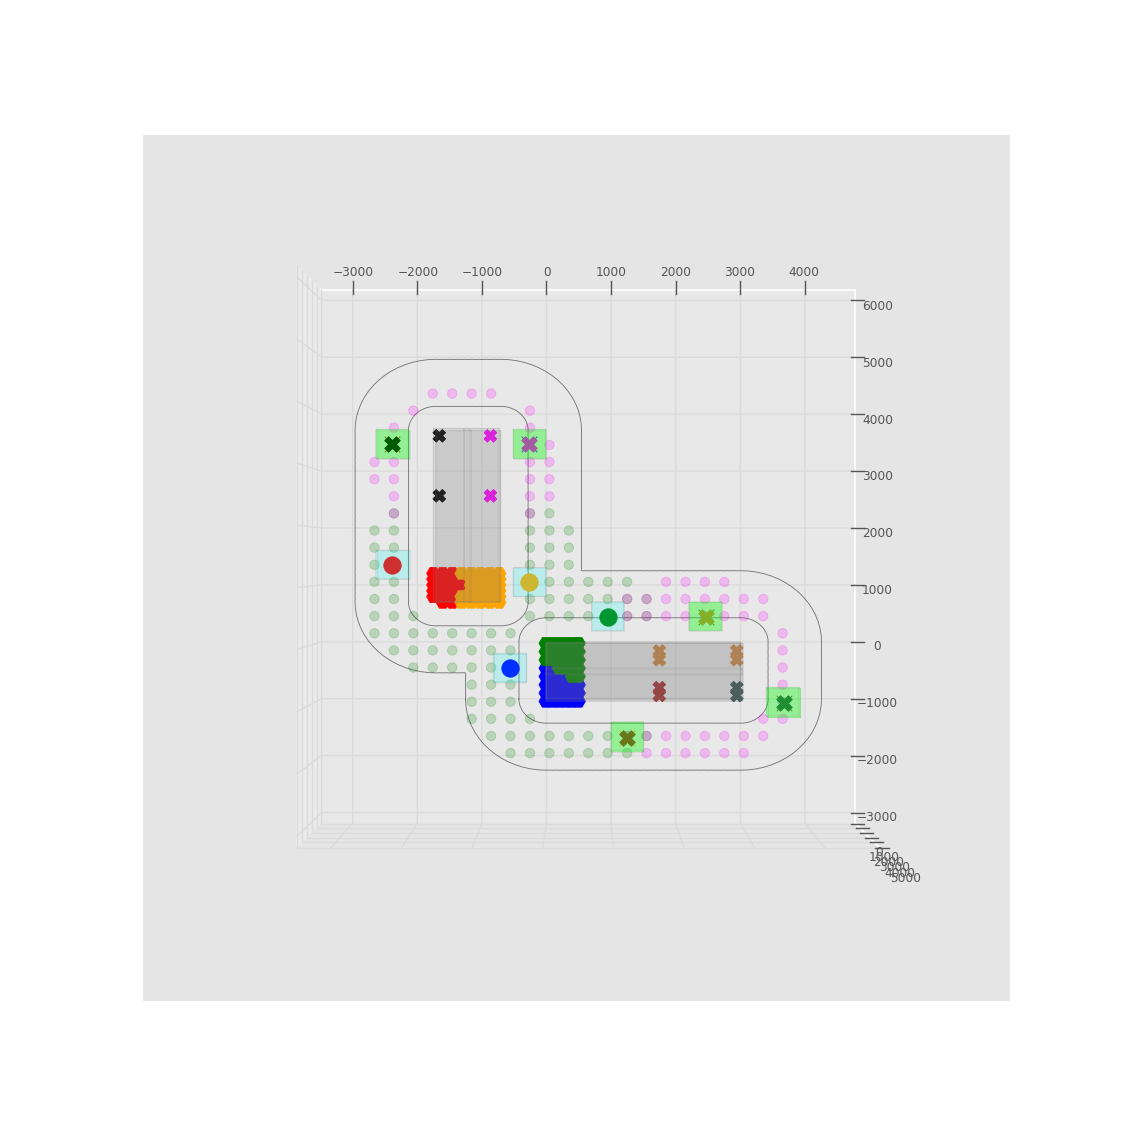

In [24]:
colors = ["red","blue","orange","green","brown","indigo","gray","yellow",
          "cyan", "purple","lime", "cadetblue","darkkhaki", "magenta"]

colors_discrete = ["black","fuchsia","brown","peru","darkslategray","gold","lime"]
fig_allocation = plt.figure(9, figsize=(9, 9))
allocation_plot     = fig_allocation.add_subplot(111, projection = "3d")
agv_coverage = {}
agv_x = 250
agv_y = 250
for i in range(len(final_combi_coverage)):
    agv_coverage = [[pbp_coverage_coords[final_combi_coverage[i]][0]+agv_x,
                     pbp_coverage_coords[final_combi_coverage[i]][1]+agv_y,
                     0],
                    [pbp_coverage_coords[final_combi_coverage[i]][0]+agv_x,
                     pbp_coverage_coords[final_combi_coverage[i]][1]-agv_y,
                     0],
                    [pbp_coverage_coords[final_combi_coverage[i]][0]-agv_x,
                     pbp_coverage_coords[final_combi_coverage[i]][1]-agv_y,
                     0],                      
                    [pbp_coverage_coords[final_combi_coverage[i]][0]-agv_x,
                     pbp_coverage_coords[final_combi_coverage[i]][1]+agv_y,
                     0],
                   
                    [pbp_coverage_coords[final_combi_coverage[i]][0]+agv_x,
                     pbp_coverage_coords[final_combi_coverage[i]][1]+agv_y,
                     600],
                    [pbp_coverage_coords[final_combi_coverage[i]][0]+agv_x,
                     pbp_coverage_coords[final_combi_coverage[i]][1]-agv_y,
                     600],
                    [pbp_coverage_coords[final_combi_coverage[i]][0]-agv_x,
                     pbp_coverage_coords[final_combi_coverage[i]][1]-agv_y,
                     600],                      
                    [pbp_coverage_coords[final_combi_coverage[i]][0]-agv_x,
                     pbp_coverage_coords[final_combi_coverage[i]][1]+agv_y,
                     600],       
                  ]
    verts_agv_coverage = [[agv_coverage[0],agv_coverage[1],agv_coverage[2],agv_coverage[3]],
                          [agv_coverage[4],agv_coverage[5],agv_coverage[6],agv_coverage[7]],
                          [agv_coverage[0],agv_coverage[4],agv_coverage[7],agv_coverage[3]],
                          [agv_coverage[0],agv_coverage[1],agv_coverage[5],agv_coverage[4]],
                          [agv_coverage[1],agv_coverage[2],agv_coverage[6],agv_coverage[5]],
                          [agv_coverage[2],agv_coverage[3],agv_coverage[7],agv_coverage[6]]
                          ]
    allocation_plot.add_collection3d(Poly3DCollection(verts_agv_coverage, facecolors='cyan', edgecolors = "gray", alpha=.1,linewidths=0.05))   
agv_discrete = {}
for i in range(len(final_combi_discrete)):
    agv_discrete = [[pbp_discrete_coords[final_combi_discrete[i]][0]+agv_x,
                     pbp_discrete_coords[final_combi_discrete[i]][1]+agv_y,
                     0],
                    [pbp_discrete_coords[final_combi_discrete[i]][0]+agv_x,
                     pbp_discrete_coords[final_combi_discrete[i]][1]-agv_y,
                     0],
                    [pbp_discrete_coords[final_combi_discrete[i]][0]-agv_x,
                     pbp_discrete_coords[final_combi_discrete[i]][1]-agv_y,
                     0],                      
                    [pbp_discrete_coords[final_combi_discrete[i]][0]-agv_x,
                     pbp_discrete_coords[final_combi_discrete[i]][1]+agv_y,
                     0],
                   
                    [pbp_discrete_coords[final_combi_discrete[i]][0]+agv_x,
                     pbp_discrete_coords[final_combi_discrete[i]][1]+agv_y,
                     600],
                    [pbp_discrete_coords[final_combi_discrete[i]][0]+agv_x,
                     pbp_discrete_coords[final_combi_discrete[i]][1]-agv_y,
                     600],
                    [pbp_discrete_coords[final_combi_discrete[i]][0]-agv_x,
                     pbp_discrete_coords[final_combi_discrete[i]][1]-agv_y,
                     600],                      
                    [pbp_discrete_coords[final_combi_discrete[i]][0]-agv_x,
                     pbp_discrete_coords[final_combi_discrete[i]][1]+agv_y,
                     600],       
                  ]
    verts_agv_discrete = [[agv_discrete[0],agv_discrete[1],agv_discrete[2],agv_discrete[3]],
                          [agv_discrete[4],agv_discrete[5],agv_discrete[6],agv_discrete[7]],
                          [agv_discrete[0],agv_discrete[4],agv_discrete[7],agv_discrete[3]],
                          [agv_discrete[0],agv_discrete[1],agv_discrete[5],agv_discrete[4]],
                          [agv_discrete[1],agv_discrete[2],agv_discrete[6],agv_discrete[5]],
                          [agv_discrete[2],agv_discrete[3],agv_discrete[7],agv_discrete[6]]
                          ]
    allocation_plot.add_collection3d(Poly3DCollection(verts_agv_discrete, facecolors='lime', edgecolors = "gray", alpha=.2,linewidths=0.05))
#plot inner/outer bounds of the search space around the product
allocation_plot.plot3D(np.array(inner_bound1)[:,0],
               np.array(inner_bound1)[:,1],
               np.array(z_in1),
               c = "black",  alpha = 0.5 )
allocation_plot.plot3D(np.array(inner_bound2)[:,0],
               np.array(inner_bound2)[:,1],
               np.array(z_in2),
               c = "black",  alpha = 0.5 )
allocation_plot.plot3D(np.array(common_ss_exterior)[:,0],
            np.array(common_ss_exterior)[:,1],
            np.array(common_ss_exterior)[:,2],
            c = "black", alpha = 0.5)
#plot allocated task points
labels_coverage =[]
for i in range(len(pbp_coverage_coords)):
    labels_coverage.append(i) 
for i in range(len(task_allocation_coverage)):
    allocation_plot.scatter(np.array(task_allocation_coverage[i])[:,0],
                            np.array(task_allocation_coverage[i])[:,1],
                            np.array(task_allocation_coverage[i])[:,2],
                            c = colors[i], marker = 'H', s = 60)

    
for i in range(len(task_allocation_discrete)):
    allocation_plot.scatter(np.array(task_allocation_discrete[i])[:,0],
                            np.array(task_allocation_discrete[i])[:,1],
                            np.array(task_allocation_discrete[i])[:,2],
                            c = colors_discrete[i], marker = 'X', s = 50)      
#plot final base placements
for i in range(len(final_combi_coverage)):
    allocation_plot.scatter(pbp_coverage_coords[final_combi_coverage[i]][0],
                            pbp_coverage_coords[final_combi_coverage[i]][1],
                            pbp_coverage_coords[final_combi_coverage[i]][2],
                            c = colors[i], s= 100, marker = "o")
    allocation_plot.scatter(final_bases_coverage[i][0],
                                final_bases_coverage[i][1],
                            final_bases_coverage[i][2],
                            c = colors[i], s= 80, marker = "o")
for i in range(len(final_combi_discrete)):
    allocation_plot.scatter(final_bases_discrete[i][0],
                            final_bases_discrete[i][1],
                            final_bases_discrete[i][2],
                            c = colors[i], s= 80, marker = "x")
    
for i in range(len(final_combi_discrete)):
    allocation_plot.scatter(pbp_discrete_coords[final_combi_discrete[i]][0],
                            pbp_discrete_coords[final_combi_discrete[i]][1],
                            pbp_discrete_coords[final_combi_discrete[i]][2],
                            c = colors_discrete[i], s= 80, marker = 'X')

allocation_plot.scatter(np.array(pbp_coverage_coords)[:,0],
                        np.array(pbp_coverage_coords)[:,1],
                        0,
                        s = 30 , alpha = 0.2, c = "green")

allocation_plot.scatter(np.array(pbp_discrete_coords)[:,0],
                np.array(pbp_discrete_coords)[:,1],
                0,
                s = 30 , alpha = 0.2, c = "magenta")

allocation_plot.set_zlim(0,5000)
allocation_plot.set_ylim(-3000,6000)
allocation_plot.view_init(elev = 90, azim = -90)
allocation_plot.add_collection3d(Poly3DCollection(verts1, facecolors='gray', edgecolors = "gray",linewidths=0.05, alpha=.1))
allocation_plot.add_collection3d(Poly3DCollection(verts2, facecolors='gray', edgecolors = "gray",linewidths=0.05, alpha=.1))
plt.show()